#Generate Dataset

In [1]:
import cv2
def generate_dataset():
    face_classifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

    def face_cropped(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_classifier.detectMultiScale(gray, 1.3, 5)

        if len(faces) == 0:  # Check if no faces are detected
            return None
        for (x, y, w, h) in faces:
            cropped_face = img[y:y+h, x:x+w]
            return cropped_face  # Return the first detected face

    cap = cv2.VideoCapture(0)  # Use default camera (index 0)
    id = 1
    img_id = 0

    while True:
        ret, frame = cap.read()
        if not ret:  # Handle case where frame is not read correctly
            print("Failed to capture image")
            break
        face = face_cropped(frame)
        if face is not None:
            img_id += 1
            face = cv2.resize(face, (200, 200))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            file_name_path = "data/user." + str(id) + "." + str(img_id) + ".jpg"
            cv2.imwrite(file_name_path, face)
            cv2.putText(face, str(img_id), (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)

            cv2.imshow("Cropped face", face)

        if cv2.waitKey(1) == 13 or int(img_id) == 400:  # 13 is the ASCII character for Enter
            break

    print("Collecting samples is completed....")
    cap.release()
    cv2.destroyAllWindows()
    

generate_dataset()



#Train the Classifier and save it

In [1]:
import cv2
import numpy as np
import os
from PIL import Image

def train_classifier(data_dir):
    paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.jpg')]
    faces, ids = [], []

    for image in paths:
        img = Image.open(image).convert('L')
        image_np = np.array(img, 'uint8')
        id = int(os.path.split(image)[1].split(".")[1])
        faces.append(image_np)
        ids.append(id)

    ids = np.array(ids)
    
    clf = cv2.face.LBPHFaceRecognizer_create()
    clf.train(faces, ids)
    clf.write("classifier.xml")

train_classifier("data")


#Detect face and name it if it is already stored in the dataset

Highest Accuracy = 88


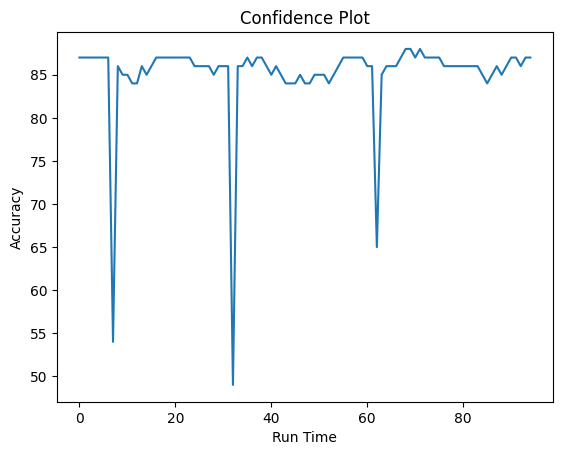

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

def draw_boundary(img, classifier, scaleFactor, minNeighbors, color, clf):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = classifier.detectMultiScale(gray_img, scaleFactor, minNeighbors)
    confidences = []

    for (x, y, w, h) in features:
        roi_gray = gray_img[y:y+h, x:x+w]
        if roi_gray.size == 0:
            continue  # Skip if ROI is empty
        id, confidence = clf.predict(roi_gray)
        confidence = int(100 * (1 - confidence / 300))
        confidences.append(confidence)
        name = "Unknown" if confidence <= 80 else ["Ujjwal", "Sujan", "Bikash", "Bijesh"][id - 1]
        cv2.putText(img, name, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 1, cv2.LINE_AA)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)

    return img, confidences

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
clf = cv2.face.LBPHFaceRecognizer_create()
clf.read("classifier.xml")

video_capture = cv2.VideoCapture(0)
accuracy, start_time, run_time = [], time.time(), 15

while True:
    ret, img = video_capture.read()
    if not ret:
        print("Failed to capture image")
        break
    
    img, confidences = draw_boundary(img, faceCascade, 1.1, 5, (255, 255, 255), clf)
    if confidences:
        accuracy.extend(confidences)
    
    cv2.imshow("Face Detection", img)
    
    if cv2.waitKey(1) == 13 or (time.time() - start_time) >= run_time:
        break

print('Highest Accuracy =', np.max(accuracy))

if accuracy:
    plt.plot(accuracy)
    plt.ylabel('Accuracy')
    plt.xlabel('Run Time')
    plt.title('Confidence Plot')
    plt.show()

video_capture.release()
cv2.destroyAllWindows()


#For Preceision curve

Highest Accuracy = 0.0525


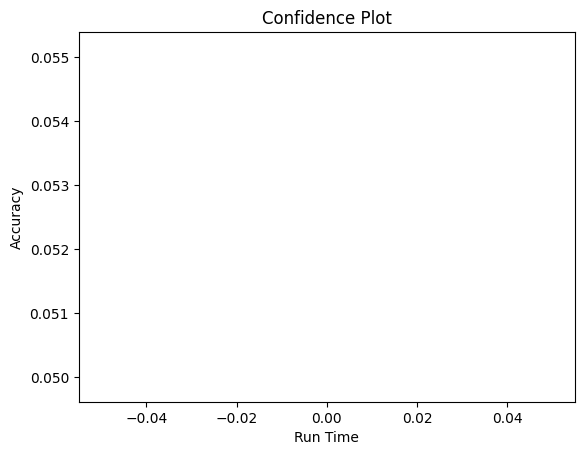

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, accuracy_score
import os

# Function to detect faces and return confidence scores
def detect_faces(image, face_cascade):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    return faces

# Load dataset
data_dir = 'C:/Users/ujjwal/Face Recognizer/data'
dataset = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            path = os.path.join(root, file)
            img = cv2.imread(path)
            label = int(file.split('.')[1])  # Extract label from filename
            dataset.append((img, label))

# Load trained classifier
clf = cv2.face.LBPHFaceRecognizer_create()
clf.read("classifier.xml")

# Initialize lists to store true labels and predictions
true_labels = []
pred_scores = []

# Load Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Run face detection and classification on the dataset
for image, label in dataset:
    faces = detect_faces(image, face_cascade)
    if len(faces) > 0:
        # Assume highest confidence for the first detected face
        x, y, w, h = faces[0]
        gray_face = cv2.cvtColor(image[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)
        label_pred, confidence = clf.predict(gray_face)
        # Consider a successful detection if confidence is high (adjust threshold as needed)
        if confidence < 100:  # Example threshold, adjust as per your model's behavior
            pred_scores.append(1)  # Detected face
        else:
            pred_scores.append(0)  # Face not detected
    else:
        pred_scores.append(0)  # No face detected

    true_labels.append(1 if label == 1 else 0)  # Convert to binary label

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(true_labels, pred_scores)

# Calculate accuracy (optional)
accuracy = accuracy_score(true_labels, pred_scores)

# Plot Precision-Recall curve
plt.plot(recall, precision, marker='.', label='Haar Cascade')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Print accuracy (optional)
print(f'Accuracy: {accuracy:.2f}')
